In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from torchnet.meter import MovingAverageValueMeter
from tqdm import tqdm
from sklearn.model_selection import KFold

from deeplab_vandaele import load_model
from utils import get_device
from dataset import RiverDataset
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
from omegaconf import OmegaConf
from scipy import ndimage
from deeplab.utils import DenseCRF, PolynomialLR, scores
from PIL import Image
from utils import preprocessing, white_mask

In [2]:
device = get_device()

Device: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
config_path = './weights/water.yaml'

CONFIG = OmegaConf.load(config_path)
torch.backends.cudnn.benchmark = True

## Import Dataset and Model 

In [4]:
dataset = RiverDataset("images")

# split the dataset in train and test set
# torch.manual_seed(1)
# train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

# define training and validation data loaders
# dataloader_train = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
# dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = load_model(device)

## Setup Optimizer and Loss Function

In [5]:
# Loss definition
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [6]:
def get_params(model, key):
    # For Dilated FCN
    if key == "1x":
        for m in model.named_modules():
            if "layer" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    for p in m[1].parameters():
                        yield p
    # For conv weight in the ASPP module
    if key == "10x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].weight
    # For conv bias in the ASPP module
    if key == "20x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].bias

# Optimizer
optimizer = torch.optim.SGD(
    # cf lr_mult and decay_mult in train.prototxt
    params=[
        {
            "params": get_params(model.module, key="1x"),
            "lr": CONFIG.SOLVER.LR,
            "weight_decay": CONFIG.SOLVER.WEIGHT_DECAY,
        },
        {
            "params": get_params(model.module, key="10x"),
            "lr": 10 * CONFIG.SOLVER.LR,
            "weight_decay": CONFIG.SOLVER.WEIGHT_DECAY,
        },
        {
            "params": get_params(model.module, key="20x"),
            "lr": 20 * CONFIG.SOLVER.LR,
            "weight_decay": 0.0,
        },
    ],
    momentum=CONFIG.SOLVER.MOMENTUM,
)

In [7]:
# Learning rate scheduler
scheduler = PolynomialLR(
    optimizer=optimizer,
    step_size=CONFIG.SOLVER.LR_DECAY,
    iter_max=CONFIG.SOLVER.ITER_MAX,
    power=CONFIG.SOLVER.POLY_POWER,
)

In [8]:
# Setup loss logger
writer = SummaryWriter(os.path.join(CONFIG.EXP.OUTPUT_DIR, "logs", CONFIG.EXP.ID))
average_loss = MovingAverageValueMeter(CONFIG.SOLVER.AVERAGE_LOSS)

In [9]:
def makedirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

# Path to save models
checkpoint_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    CONFIG.MODEL.NAME.lower()
)

makedirs(checkpoint_dir)

print("Checkpoint dst:", checkpoint_dir)

Checkpoint dst: water_output\deeplabv2_resnet101_msc


In [10]:
def resize_labels(labels, size):
    """
    Downsample labels for 0.5x and 0.75x logits by nearest interpolation.
    Other nearest methods result in misaligned labels.
    -> F.interpolate(labels, shape, mode='nearest')
    -> cv2.resize(labels, shape, interpolation=cv2.INTER_NEAREST)
    """
    new_labels = []
    for label in labels:
        label = label.float().numpy()
        label = Image.fromarray(label).resize(size, resample=Image.NEAREST)
        new_labels.append(np.asarray(label))
    new_labels = torch.LongTensor(np.array(new_labels))
    return new_labels

## Training K-Folds

In [11]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
scores_store = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold + 1}')
    print('--------------------------------')
    print(len(train_ids), len(test_ids))
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_subsampler)
    
    # Freeze the batch norm pre-trained on COCO
    model.train()
    model.module.base.freeze_bn()
    
    for iteration in tqdm(
        range(1, CONFIG.SOLVER.ITER_MAX + 1),
        total=CONFIG.SOLVER.ITER_MAX,
        dynamic_ncols=True,
    ):
        # Clear gradients (ready to accumulate)
        optimizer.zero_grad()
        
        loss = 0
        for _ in range(CONFIG.SOLVER.ITER_SIZE):
            for boolean in [True, False]:
                try:
                    _, images, labels = next(loader_iter, boolean)
                except:
                    loader_iter = iter(trainloader)
                    _, images, labels = next(loader_iter, boolean)

                # Propagate forward
                logits = model(images.to(device))

                # Loss
                iter_loss = 0
                for logit in logits:
                    # Resize labels for {100%, 75%, 50%, Max} logits
                    _, _, H, W = logit.shape
                    labels_ = resize_labels(labels, size=(W, H))
                    iter_loss += criterion(logit, labels_.to(device))

                # Propagate backward (just compute gradients)
                iter_loss /= CONFIG.SOLVER.ITER_SIZE
                iter_loss.backward()

                loss += float(iter_loss)

        average_loss.add(loss)

        # Update weights with accumulated gradients
        optimizer.step()

        # Update learning rate
        scheduler.step(epoch=iteration)

        # TensorBoard
        if iteration % CONFIG.SOLVER.ITER_TB == 0:
            writer.add_scalar("loss/train", average_loss.value()[0], iteration)
            for i, o in enumerate(optimizer.param_groups):
                writer.add_scalar("lr/group_{}".format(i), o["lr"], iteration)
            for i in range(torch.cuda.device_count()):
                writer.add_scalar(
                    "gpu/device_{}/memory_cached".format(i),
                    torch.cuda.memory_cached(i) / 1024 ** 3,
                    iteration,
                )

            if False:
                for name, param in model.module.base.named_parameters():
                    name = name.replace(".", "/")
                    # Weight/gradient distribution
                    writer.add_histogram(name, param, iteration, bins="auto")
                    if param.requires_grad:
                        writer.add_histogram(
                            name + "/grad", param.grad, iteration, bins="auto"
                        )

        # Save a model
        if iteration % CONFIG.SOLVER.ITER_SAVE == 0:
            torch.save(
                model.module.state_dict(),
                os.path.join(checkpoint_dir, "{}_fold_checkpoint_{}.pth".format(fold + 1, iteration)),
            )
            
    model.eval()

    preds, gts = [], []
    for image_ids, images, gt_labels in tqdm(
        testloader, total=len(testloader), dynamic_ncols=True
    ):
        # Image
        images = images.to(device)

        # Forward propagation
        logits = model(images)

        # Pixel-wise labeling
        _, H, W = gt_labels.shape
        logits = F.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        probs = F.softmax(logits, dim=1)
        labels = torch.argmax(probs, dim=1)

        preds += list(labels.cpu().numpy())
        gts += list(gt_labels.numpy())

    # Pixel Accuracy, Mean Accuracy, Class IoU, Mean IoU, Freq Weighted IoU
    score = scores(gts, preds, n_class=CONFIG.DATASET.N_CLASSES)
    scores_store.append(score)
    
    print(score)

FOLD 1
--------------------------------
288 72


  0%|                                                                                                                                                                                                     | 0/100 [00:00<?, ?it/s]C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnin

{'Pixel Accuracy': 0.9359562475887345, 'Mean Accuracy': 0.8955512676515263, 'Frequency Weighted IoU': 0.8789462567921346, 'Mean IoU': 0.8453911106849407, 'Class IoU': {0: 0.7726422749960837, 1: 0.9181399463737976}}
FOLD 2
--------------------------------
288 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:38<00:00,  1.87it/s]


{'Pixel Accuracy': 0.9431677999614198, 'Mean Accuracy': 0.9035451281609809, 'Frequency Weighted IoU': 0.8918050734891261, 'Mean IoU': 0.8591013836711163, 'Class IoU': {0: 0.7905558197982686, 1: 0.927646947543964}}
FOLD 3
--------------------------------
288 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:31<00:00,  2.29it/s]


{'Pixel Accuracy': 0.9370896629050925, 'Mean Accuracy': 0.9143030582651703, 'Frequency Weighted IoU': 0.8832736785109883, 'Mean IoU': 0.8495479555403224, 'Class IoU': {0: 0.7800767660964772, 1: 0.9190191449841675}}
FOLD 4
--------------------------------
288 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:31<00:00,  2.28it/s]


{'Pixel Accuracy': 0.9484448543595679, 'Mean Accuracy': 0.9081061914609203, 'Frequency Weighted IoU': 0.9009060550064093, 'Mean IoU': 0.8709813661350677, 'Class IoU': {0: 0.8077763075945887, 1: 0.9341864246755467}}
FOLD 5
--------------------------------
288 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:31<00:00,  2.27it/s]

{'Pixel Accuracy': 0.9499390552662037, 'Mean Accuracy': 0.9162156593274496, 'Frequency Weighted IoU': 0.9048866411278608, 'Mean IoU': 0.870682207410075, 'Class IoU': {0: 0.8044038924626637, 1: 0.9369605223574862}}


In [12]:
scores_store

[{'Pixel Accuracy': 0.9359562475887345,
  'Mean Accuracy': 0.8955512676515263,
  'Frequency Weighted IoU': 0.8789462567921346,
  'Mean IoU': 0.8453911106849407,
  'Class IoU': {0: 0.7726422749960837, 1: 0.9181399463737976}},
 {'Pixel Accuracy': 0.9431677999614198,
  'Mean Accuracy': 0.9035451281609809,
  'Frequency Weighted IoU': 0.8918050734891261,
  'Mean IoU': 0.8591013836711163,
  'Class IoU': {0: 0.7905558197982686, 1: 0.927646947543964}},
 {'Pixel Accuracy': 0.9370896629050925,
  'Mean Accuracy': 0.9143030582651703,
  'Frequency Weighted IoU': 0.8832736785109883,
  'Mean IoU': 0.8495479555403224,
  'Class IoU': {0: 0.7800767660964772, 1: 0.9190191449841675}},
 {'Pixel Accuracy': 0.9484448543595679,
  'Mean Accuracy': 0.9081061914609203,
  'Frequency Weighted IoU': 0.9009060550064093,
  'Mean IoU': 0.8709813661350677,
  'Class IoU': {0: 0.8077763075945887, 1: 0.9341864246755467}},
 {'Pixel Accuracy': 0.9499390552662037,
  'Mean Accuracy': 0.9162156593274496,
  'Frequency Weighted 

## Training Original

In [12]:
# Freeze the batch norm pre-trained on COCO
model.train()
model.module.base.freeze_bn()

loader_iter = iter(dataloader_train)

for iteration in tqdm(
    range(1, CONFIG.SOLVER.ITER_MAX + 1),
    total=CONFIG.SOLVER.ITER_MAX,
    dynamic_ncols=True,
):

    # Clear gradients (ready to accumulate)
    optimizer.zero_grad()

    loss = 0
    for _ in range(CONFIG.SOLVER.ITER_SIZE):
        for boolean in [True, False]:
            try:
                _, images, labels = next(loader_iter, boolean)
            except:
                loader_iter = iter(dataloader_train)
                _, images, labels = next(loader_iter, boolean)

            # Propagate forward
            logits = model(images.to(device))

            # Loss
            iter_loss = 0
            for logit in logits:
                # Resize labels for {100%, 75%, 50%, Max} logits
                _, _, H, W = logit.shape
                labels_ = resize_labels(labels, size=(W, H))
                iter_loss += criterion(logit, labels_.to(device))

            # Propagate backward (just compute gradients)
            iter_loss /= CONFIG.SOLVER.ITER_SIZE
            iter_loss.backward()

            loss += float(iter_loss)
        
    average_loss.add(loss)

    # Update weights with accumulated gradients
    optimizer.step()

    # Update learning rate
    scheduler.step(epoch=iteration)

    # TensorBoard
    if iteration % CONFIG.SOLVER.ITER_TB == 0:
        writer.add_scalar("loss/train", average_loss.value()[0], iteration)
        for i, o in enumerate(optimizer.param_groups):
            writer.add_scalar("lr/group_{}".format(i), o["lr"], iteration)
        for i in range(torch.cuda.device_count()):
            writer.add_scalar(
                "gpu/device_{}/memory_cached".format(i),
                torch.cuda.memory_cached(i) / 1024 ** 3,
                iteration,
            )

        if False:
            for name, param in model.module.base.named_parameters():
                name = name.replace(".", "/")
                # Weight/gradient distribution
                writer.add_histogram(name, param, iteration, bins="auto")
                if param.requires_grad:
                    writer.add_histogram(
                        name + "/grad", param.grad, iteration, bins="auto"
                    )

    # Save a model
    if iteration % CONFIG.SOLVER.ITER_SAVE == 0:
        torch.save(
            model.module.state_dict(),
            os.path.join(checkpoint_dir, "checkpoint_{}.pth".format(iteration)),
        )

  0%|                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
  1%|█▋                                                                                                                                                                       | 1/100 [00:14<23:23, 14.18s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  2%|███▍                                                                                                                                                                     | 2/100 [00:18<13:28,  8.25s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  3%|█████                                                                                                                                                                    | 3/100 [00:24<11:50,  7.32s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  4%|██████▊                                                                                                                                                                  | 4/100 [00:30<10:52,  6.80s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  5%|████████▍                                                                                                                                                                | 5/100 [00:36<10:22,  6.56s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  6%|██████████▏                                                                                                                                                              | 6/100 [00:41<09:19,  5.95s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  7%|███████████▊                                                                                                                                                             | 7/100 [00:46<08:38,  5.58s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  8%|█████████████▌                                                                                                                                                           | 8/100 [00:50<08:00,  5.23s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


  9%|███████████████▏                                                                                                                                                         | 9/100 [00:57<08:27,  5.58s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 10%|████████████████▊                                                                                                                                                       | 10/100 [01:01<07:44,  5.16s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 11%|██████████████████▍                                                                                                                                                     | 11/100 [01:07<08:03,  5.43s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 12%|████████████████████▏                                                                                                                                                   | 12/100 [01:12<07:46,  5.30s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 13%|█████████████████████▊                                                                                                                                                  | 13/100 [01:17<07:32,  5.20s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 14%|███████████████████████▌                                                                                                                                                | 14/100 [01:21<07:04,  4.94s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 15%|█████████████████████████▏                                                                                                                                              | 15/100 [01:27<07:17,  5.14s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 16%|██████████████████████████▉                                                                                                                                             | 16/100 [01:31<06:56,  4.96s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 17%|████████████████████████████▌                                                                                                                                           | 17/100 [01:36<06:43,  4.86s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 18%|██████████████████████████████▏                                                                                                                                         | 18/100 [01:41<06:47,  4.97s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 19%|███████████████████████████████▉                                                                                                                                        | 19/100 [01:46<06:40,  4.95s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 20%|█████████████████████████████████▌                                                                                                                                      | 20/100 [01:51<06:36,  4.96s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 21%|███████████████████████████████████▎                                                                                                                                    | 21/100 [01:56<06:33,  4.98s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 22%|████████████████████████████████████▉                                                                                                                                   | 22/100 [02:00<06:06,  4.70s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 23%|██████████████████████████████████████▋                                                                                                                                 | 23/100 [02:05<05:56,  4.63s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 24%|████████████████████████████████████████▎                                                                                                                               | 24/100 [02:09<05:58,  4.71s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 25%|██████████████████████████████████████████                                                                                                                              | 25/100 [02:16<06:34,  5.27s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 26%|███████████████████████████████████████████▋                                                                                                                            | 26/100 [02:21<06:21,  5.15s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 27%|█████████████████████████████████████████████▎                                                                                                                          | 27/100 [02:28<07:03,  5.80s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 28%|███████████████████████████████████████████████                                                                                                                         | 28/100 [02:35<07:11,  5.99s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 29%|████████████████████████████████████████████████▋                                                                                                                       | 29/100 [02:39<06:36,  5.59s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 30/100 [02:44<06:02,  5.18s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 31%|████████████████████████████████████████████████████                                                                                                                    | 31/100 [02:48<05:48,  5.06s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 32/100 [02:53<05:41,  5.03s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 33/100 [02:58<05:34,  4.99s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 34%|█████████████████████████████████████████████████████████                                                                                                               | 34/100 [03:03<05:27,  4.96s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 35/100 [03:08<05:22,  4.97s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 36/100 [03:13<05:16,  4.95s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 37/100 [03:21<06:04,  5.78s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 38/100 [03:25<05:40,  5.49s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 39/100 [03:30<05:21,  5.26s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 40/100 [03:35<05:09,  5.16s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 41/100 [03:40<04:51,  4.94s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 42/100 [03:46<05:07,  5.30s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 43/100 [03:51<04:54,  5.16s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 44/100 [03:55<04:38,  4.97s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 45/100 [03:59<04:22,  4.77s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 46/100 [04:06<04:46,  5.31s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 47/100 [04:11<04:34,  5.18s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 48/100 [04:16<04:22,  5.05s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 49/100 [04:22<04:34,  5.37s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 50/100 [04:26<04:19,  5.19s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 51/100 [04:31<04:06,  5.04s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 52/100 [04:36<03:56,  4.92s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 53/100 [04:40<03:44,  4.77s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 54/100 [04:44<03:32,  4.61s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 55/100 [04:49<03:27,  4.61s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 56/100 [04:54<03:24,  4.65s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 57/100 [04:58<03:19,  4.63s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 58/100 [05:03<03:09,  4.52s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 59/100 [05:07<03:06,  4.54s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 60/100 [05:13<03:17,  4.93s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 61/100 [05:17<03:06,  4.79s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 62/100 [05:23<03:15,  5.13s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 63/100 [05:28<03:00,  4.87s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 64/100 [05:32<02:54,  4.85s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 65/100 [05:37<02:48,  4.82s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 66/100 [05:42<02:41,  4.75s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 67/100 [05:46<02:35,  4.70s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 68/100 [05:52<02:43,  5.12s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 69/100 [05:59<02:47,  5.41s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 70/100 [06:03<02:30,  5.01s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 71/100 [06:07<02:16,  4.72s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 72/100 [06:13<02:22,  5.07s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 73/100 [06:17<02:13,  4.93s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 74/100 [06:23<02:18,  5.32s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 75/100 [06:28<02:06,  5.07s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 76/100 [06:32<01:55,  4.83s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 77/100 [06:36<01:47,  4.66s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 78/100 [06:42<01:49,  4.96s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 79/100 [06:47<01:42,  4.88s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 80/100 [06:51<01:33,  4.70s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 81/100 [06:56<01:29,  4.73s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 82/100 [07:00<01:22,  4.60s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 83/100 [07:06<01:25,  5.04s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 84/100 [07:11<01:18,  4.91s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 85/100 [07:17<01:18,  5.24s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 86/100 [07:21<01:09,  4.99s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 87/100 [07:26<01:02,  4.83s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 88/100 [07:30<00:56,  4.70s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 89/100 [07:35<00:50,  4.61s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 90/100 [07:39<00:46,  4.61s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 91/100 [07:45<00:44,  4.93s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 92/100 [07:51<00:41,  5.21s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 93/100 [07:58<00:41,  5.90s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 94/100 [08:03<00:33,  5.50s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 95/100 [08:07<00:26,  5.20s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [08:12<00:20,  5.01s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97/100 [08:17<00:15,  5.19s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [08:22<00:10,  5.03s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [08:26<00:04,  4.80s/it]

torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 46, 81])
torch.Size([2, 2, 23, 41])
torch.Size([2, 2, 34, 61])
torch.Size([2, 2, 46, 81])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.12s/it]


## Test Model

In [13]:
# Path to save logits
logit_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    "features",
    CONFIG.MODEL.NAME.lower(),
    "logit",
)

makedirs(logit_dir)
print("Logit dst:", logit_dir)

Logit dst: water_output\features\deeplabv2_resnet101_msc\logit


In [14]:
# Path to save scores
save_dir = os.path.join(
    CONFIG.EXP.OUTPUT_DIR,
    "scores",
    CONFIG.MODEL.NAME.lower(),
)
makedirs(save_dir)
save_path = os.path.join(save_dir, "scores.json")
print("Score dst:", save_path)

Score dst: water_output\scores\deeplabv2_resnet101_msc\scores.json


In [15]:
model.eval()

preds, gts = [], []
for image_ids, images, gt_labels in tqdm(
    dataloader_test, total=len(dataloader_test), dynamic_ncols=True
):
    # Image
    images = images.to(device)

    # Forward propagation
    logits = model(images)

    # Save on disk for CRF post-processing
    for image_id, logit in zip(image_ids, logits):
        filename = os.path.join(logit_dir, image_id + ".npy")
        np.save(filename, logit.detach().cpu().numpy())

    # Pixel-wise labeling
    _, H, W = gt_labels.shape
    logits = F.interpolate(
        logits, size=(H, W), mode="bilinear", align_corners=False
    )
    probs = F.softmax(logits, dim=1)
    labels = torch.argmax(probs, dim=1)

    preds += list(labels.cpu().numpy())
    gts += list(gt_labels.numpy())

# Pixel Accuracy, Mean Accuracy, Class IoU, Mean IoU, Freq Weighted IoU
score = scores(gts, preds, n_class=CONFIG.DATASET.N_CLASSES)

with open(save_path, "w") as f:
    json.dump(score, f, indent=4, sort_keys=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:35<00:00,  2.02it/s]


In [16]:
score

{'Pixel Accuracy': 0.9311107494212963,
 'Mean Accuracy': 0.8938309928613191,
 'Frequency Weighted IoU': 0.8709415749803815,
 'Mean IoU': 0.8370522227730741,
 'Class IoU': {0: 0.7625659063016366, 1: 0.9115385392445118}}

In [19]:
score

{'Pixel Accuracy': 0.9311107494212963,
 'Mean Accuracy': 0.8938309928613191,
 'Frequency Weighted IoU': 0.8709415749803815,
 'Mean IoU': 0.8370522227730741,
 'Class IoU': {0: 0.7625659063016366, 1: 0.9115385392445118}}

## Visualize an Image

In [23]:
img_id, img, mask = dataset.__getitem__(330)

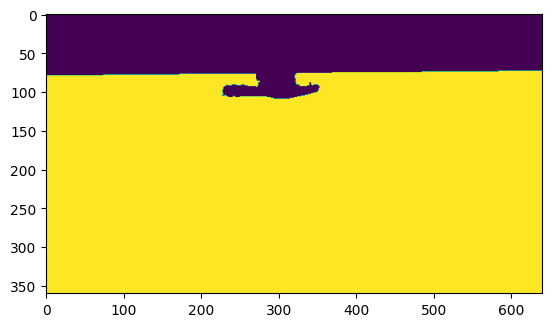

In [24]:
plt.imshow(mask)

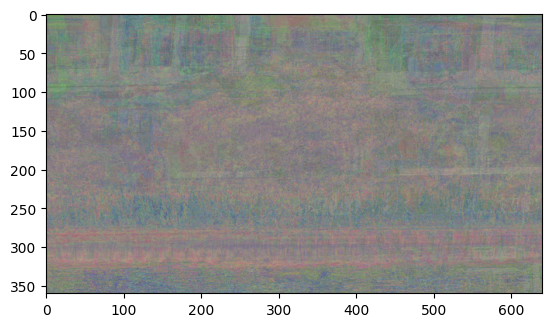

In [25]:
plt.imshow(to_pil_image(torch.Tensor(img)))

## Retrieving Model

In [16]:
from deeplab.models import DeepLabV2_ResNet101_MSC

classes = {0: 'non-river', 1: 'river'}

def load_model(device):
    model_path = './water_output/deeplabv2_resnet101_msc/checkpoint_100.pth'

    model = DeepLabV2_ResNet101_MSC(n_classes=len(classes))
    state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    model = torch.nn.DataParallel(model)
    model.eval()
    model.to(device)

    return model

model = load_model(device)

In [20]:
import torch.nn.functional as F

def remove_non_river(image, raw_image, device):
    _, _, H, W = image.shape

    # Image -> Probability map
    logits = model(image)
    logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
    probs = F.softmax(logits, dim=1)[0]
    probs = probs.detach().cpu().numpy()

    labelmap = np.argmax(probs, axis=0)

    labelmap = (labelmap.astype(bool)).astype(int)
#     labelmap = ndimage.binary_fill_holes(1 - labelmap).astype(int)
#     labelmap = ndimage.binary_fill_holes(1 - labelmap).astype(int)
#     labelmap = ndimage.binary_dilation(labelmap).astype(int)
    w_mask = white_mask(labelmap)
    raw_image = cv2.addWeighted(raw_image, 1, w_mask, 1, 0)

    return raw_image, labelmap

In [26]:
img_id

'ed95d966092ee'

In [27]:
img = cv2.imread('./images/images/%s.jpg' % (img_id))
img, raw_img = preprocessing(img, device)

res_img, res_mask = remove_non_river(img, raw_img, device)

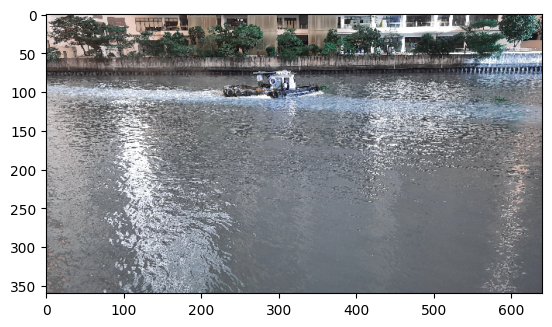

In [28]:
plt.imshow(raw_img)

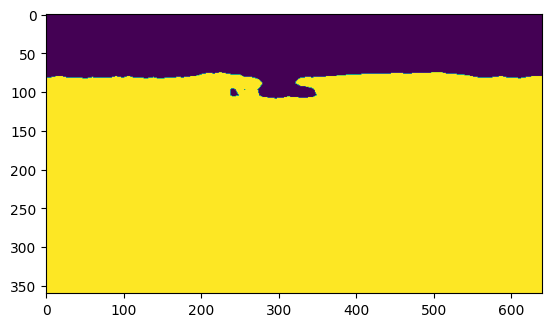

In [29]:
plt.imshow(res_mask)

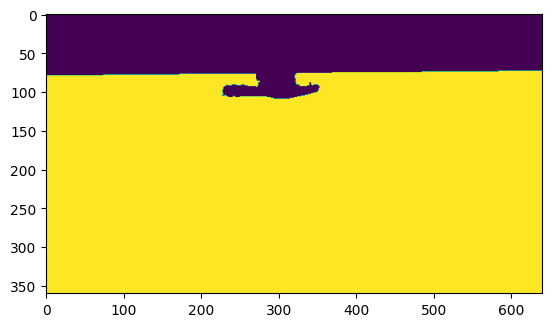

In [30]:
plt.imshow(mask)

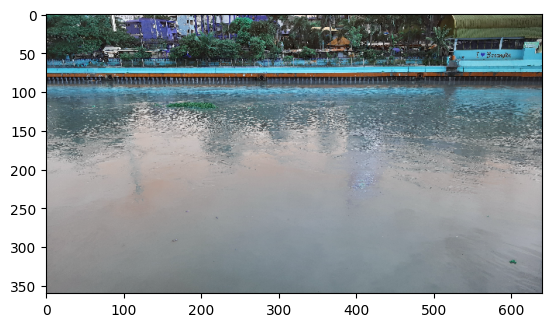

In [42]:
plt.imshow(raw_img)